In [88]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from torch.nn import functional as F
import torch as torch
import matplotlib.pyplot as plt

In [193]:
class WeatherDataset(Dataset):
    def __init__(self, path, input_columns, input_width, label_column, label_width):
        df = pd.read_csv(path)
                
        self.input_width = input_width
        self.label_width = label_width
        
        self.input_columns = input_columns
        self.label_column = label_column

            
        end_index = len(df)
        start_index = 0
        sequence_length = input_width+label_width
        num_seqs = end_index - start_index - sequence_length + 1
        self.start_positions = np.arange(0, num_seqs, 1)
        
        self.input_data = torch.tensor(df[self.input_columns].to_numpy())
        self.label_data = torch.tensor(df[self.label_column].to_numpy())
        
    def __len__(self):
        return len(self.start_positions)

    def __getitem__(self, idx):
        input_start = self.start_positions[idx]
        input_end = input_start + self.input_width
        
        label_start = input_end
        label_end = label_start + self.label_width
        return {'input':self.input_data[input_start:input_end,:],
                'label':self.label_data[label_start:label_end]}

In [196]:
input_width=6
label_width=1

In [197]:
test_dataset = WeatherDataset('test.csv',['T (degC)'],input_width,'T (degC)',label_width)
train_dataset = WeatherDataset('train.csv',['T (degC)'],input_width,'T (degC)',label_width)
val_dataset = WeatherDataset('val.csv',['T (degC)'],input_width,'T (degC)',label_width)

In [212]:
test_dataloader = DataLoader(test_dataset,batch_size=32)
val_dataloader = DataLoader(val_dataset,batch_size=32)
train_dataloader = DataLoader(train_dataset,batch_size=32)

In [229]:
class Baseline(pl.LightningModule):
    
    
    def __init__(self):
        super().__init__()
        self.test_mae = pl.metrics.MeanAbsoluteError()     
        self.valid_mae = pl.metrics.MeanAbsoluteError()
    def forward(self,x):
        return x[:,-1]
        
    def test_step(self, batch, batch_idx):
        x = batch['input']
        y = batch['label']
        yhat = self(x)
        loss = F.mse_loss(yhat, y)
        self.test_mae(yhat, y)
        self.log('test_loss', loss)
        self.log('test_mae', self.test_mae)
        
    def validation_step(self, batch, batch_idx):
        x = batch['input']
        y = batch['label']
        yhat = self(x)
        loss = F.mse_loss(yhat, y)
        self.valid_mae(yhat, y)
        self.log('val_loss', loss)
        self.log('val_mae', self.valid_mae) 


In [230]:
model = Baseline()

In [231]:
trainer = pl.Trainer(gpus=0, progress_bar_refresh_rate=20)   

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


In [236]:
trainer.test(model, val_dataloader) 


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.0128), 'test_mae': tensor(0.0785)}
--------------------------------------------------------------------------------


[{'test_loss': 0.01284965593367815, 'test_mae': 0.0784820094704628}]

In [237]:
trainer.test(model, test_dataloader) 


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.0142), 'test_mae': tensor(0.0852)}
--------------------------------------------------------------------------------


[{'test_loss': 0.014172015711665154, 'test_mae': 0.0852045789361}]

In [238]:
labels = []
predictions = []
for batch in test_dataloader:
    x = batch['input']
    y = batch['label']
    yhat = model(x)
    predictions.append(yhat)
    labels.append(y)

In [239]:
predictions = torch.cat(predictions)
labels = torch.cat(labels)

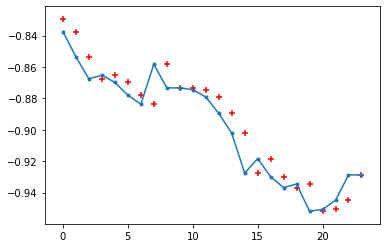

In [240]:
start=0
end=24
xaxis=np.arange(start,end)
fig, ax = plt.subplots()
ax.plot(xaxis,labels[start:end],marker='.')
ax.scatter(xaxis,predictions[start:end],color='r',marker='+')